In [1]:
# !pip install networkx
# !pip install matplotlib
# !pip install tqdm
# !pip install pandas
# !pip install numpy
# !pip install graphviz
# !pip install scikit-learn

In [2]:
import random
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations, groupby

from networkx.algorithms import tree
from networkx.algorithms import bellman_ford_predecessor_and_distance
from networkx.algorithms import floyd_warshall_predecessor_and_distance

import numpy.typing as npt

# Task 1. Analysis of Prim's Algorithm and Bellman-Ford Algorithm Performance

**Authors:**
- Vladyslav Shymanovskyi
- Taras Levytskyi

---

## Introduction

In this project, we explore and analyze the performance of two fundamental graph algorithms: **Prim’s Algorithm** for Minimum Spanning Trees (MST) and **Bellman-Ford Algorithm** for shortest paths. Our goal is to implement these algorithms and investigate their efficiency across different graph sizes and densities. We will also compare our custom implementations with NetworkX’s built-in functions to evaluate their performance and scalability.

We decided to focus on **Prim’s Algorithm** for finding Minimum Spanning Trees and **Bellman-Ford** for finding the shortest path in graphs with both positive and negative weights. For both algorithms, we performed experiments on graphs of varying sizes, edge densities, and edge weights, measuring the execution time for each scenario.

## Generating graph

At first we should generate a random **graph**

In [3]:

# You can use this function to generate a random graph with 'num_of_nodes' nodes
# and 'completeness' probability of an edge between any two nodes
# If 'directed' is True, the graph will be directed
# If 'draw' is True, the graph will be drawn
def gnp_random_connected_graph(num_of_nodes: int,
                               completeness: int,
                               directed: bool = False,
                               draw: bool = False):
    """
    Generates a random graph, similarly to an Erdős-Rényi 
    graph, but enforcing that the resulting graph is conneted (in case of undirected graphs)
    """

    
    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    edges = combinations(range(num_of_nodes), 2)
    G.add_nodes_from(range(num_of_nodes))
    
    for _, node_edges in groupby(edges, key = lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        if random.random() < 0.5:
            random_edge = random_edge[::-1]
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < completeness:
                G.add_edge(*e)
                
    for (u,v,w) in G.edges(data=True):
        w['weight'] = random.randint(-5, 20)
                
    if draw: 
        plt.figure(figsize=(10,6))
        if directed:
            # draw with edge weights
            pos = nx.arf_layout(G)
            nx.draw(G,pos, node_color='lightblue', 
                    with_labels=True,
                    node_size=500, 
                    arrowsize=20, 
                    arrows=True)
            labels = nx.get_edge_attributes(G,'weight')
            nx.draw_networkx_edge_labels(G, pos,edge_labels=labels)
            
        else:
            nx.draw(G, node_color='lightblue', 
                with_labels=True, 
                node_size=500)
        
    return G

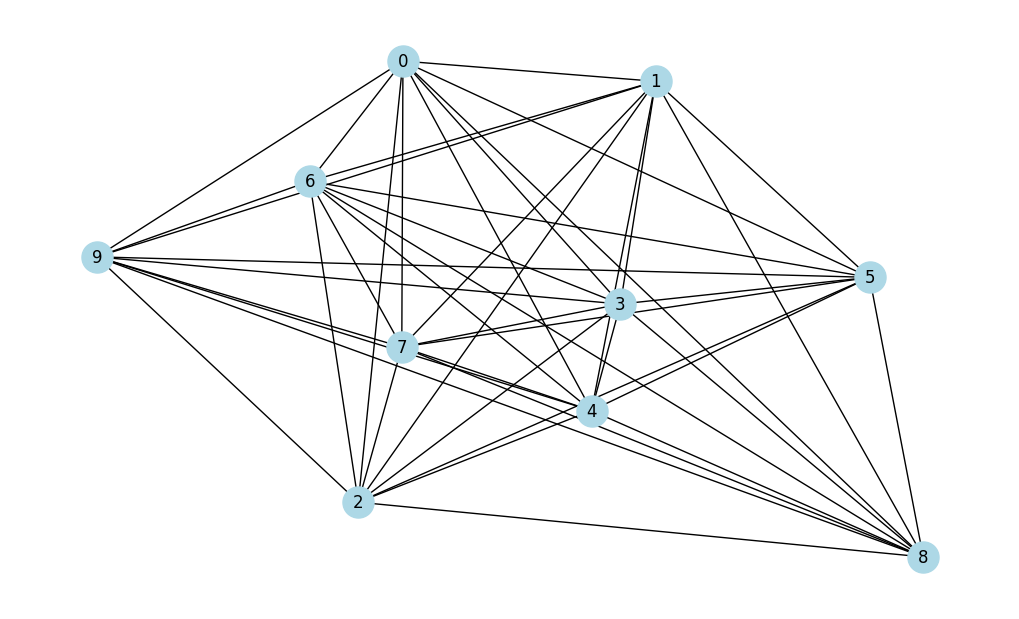

In [4]:
G = gnp_random_connected_graph(10, 1, False, True)

## Subtask 1.1: Exploring Prim’s Algorithm and Comparing with Built-In Functions

**Objective:**
The goal of this task is to investigate the performance of **Prim’s Algorithm** for finding the Minimum Spanning Tree (MST) and compare the execution times between our custom implementation and the built-in function from NetworkX.

**Experimental Setup:**
For the experiments, we generated graphs with different sizes, ranging from 10 to 300 vertices, to test how the algorithm scales with the size of the graph. Additionally, we varied the edge density by adjusting the probability of creating an edge between nodes. This allowed us to create both sparse and dense graphs.

We ran the experiments multiple times for each graph size and density to ensure reliable results. For each combination of graph size and density, we recorded the minimum execution time across several runs. Afterward, we compared the results of our custom implementation with NetworkX’s built-in **Prim’s Algorithm**.

### Built-in function

In [5]:
mstp = tree.minimum_spanning_tree(G, algorithm="prim")

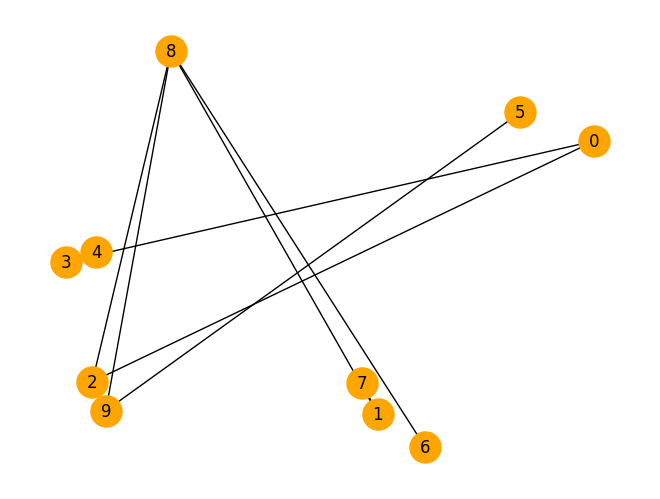

In [6]:
nx.draw(mstp, node_color='orange', 
        with_labels=True, 
        node_size=500)

In [7]:
mstp.edges(), len(mstp.edges())

(EdgeView([(0, 2), (0, 3), (1, 8), (1, 7), (2, 8), (3, 4), (5, 9), (6, 8), (8, 9)]),
 9)

### Custom function

In [8]:
def prim_algorithm(graph):
    """
    Prim algorithm for a graph with weights
    """

    graph_nodes = list(graph.nodes)
    graph_edges = list(graph.edges)
    graph_weights = nx.get_edge_attributes(graph, 'weight')

    result_edges = []
    result_nodes = [graph_nodes[0]]

    while len(result_nodes) != len(graph_nodes):
        available_edges = []
        for x, y in graph_edges:
            if (x in result_nodes and y not in result_nodes) or\
                (y in result_nodes and x not in result_nodes):
                available_edges.append((x, y))

        edge_to_compare = available_edges[0]
        for edge in available_edges:
            if graph_weights[edge] < graph_weights[edge_to_compare]:
                edge_to_compare = edge

        result_edges.append((edge_to_compare[0], edge_to_compare[1], graph_weights[edge_to_compare]))
        result_nodes.append(edge_to_compare[0] if edge_to_compare[1] in result_nodes else edge_to_compare[1])

    result_graph = nx.Graph()
    result_graph.add_weighted_edges_from(result_edges)
        
    return result_graph

In [9]:
mstp_custom = prim_algorithm(G)
mstp_custom.edges(), len(mstp_custom.edges())

(EdgeView([(0, 2), (0, 3), (2, 8), (3, 4), (8, 1), (8, 6), (8, 9), (1, 7), (9, 5)]),
 9)

### Measuring execution time

In [10]:
import time

def measure_execution_time(graph, algorithm_type='custom'):
    start_time = time.time()

    if algorithm_type == 'custom':
        prim_algorithm(graph)
    elif algorithm_type == 'networkx':
        tree.minimum_spanning_tree(graph, algorithm="prim")

    end_time = time.time()
    return end_time - start_time


In [11]:
def run_experiment(node_counts):
    results = {'custom': {'full': [], 'half': []}, 'networkx': {'full': [], 'half': []}}

    for nodes in node_counts:
        G_full = gnp_random_connected_graph(nodes, 1, False, False)

        custom_time = measure_execution_time(G_full, 'custom')
        networkx_time = measure_execution_time(G_full, 'networkx')
        results['custom']['full'].append(custom_time)
        results['networkx']['full'].append(networkx_time)

        G_half = gnp_random_connected_graph(nodes, 0.5, False, False)
        custom_time_half = measure_execution_time(G_half, 'custom')
        networkx_time_half = measure_execution_time(G_half, 'networkx')
        results['custom']['half'].append(custom_time_half)
        results['networkx']['half'].append(networkx_time_half)

    return results

node_counts = [50, 100, 200, 300]
experiment_results = run_experiment(node_counts)

KeyboardInterrupt: 

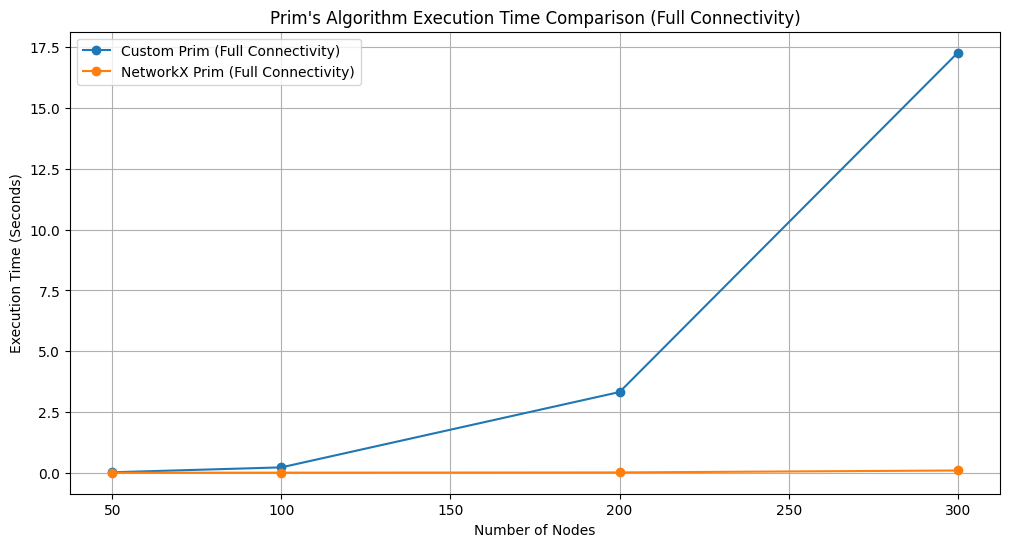

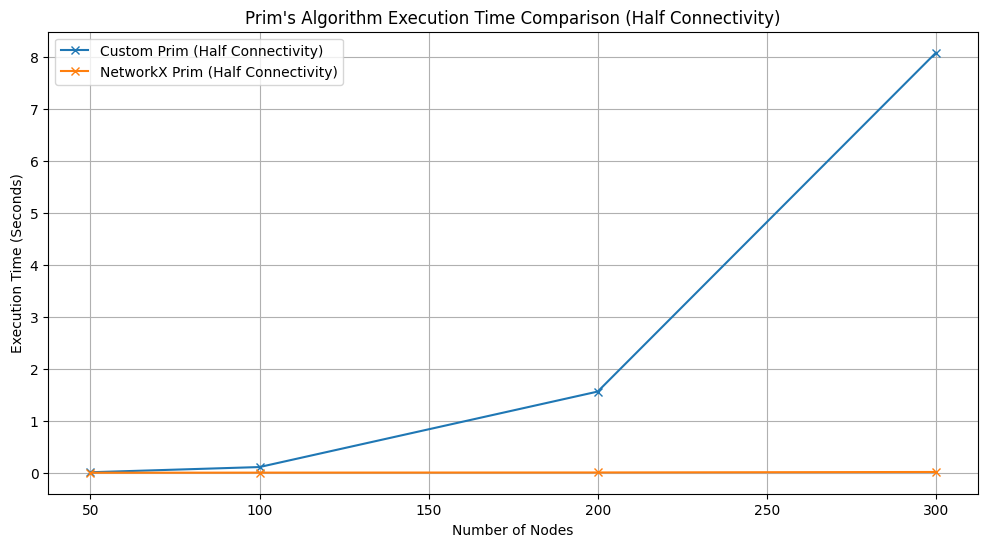

In [ ]:
def plot_results(experiment_results, node_counts):

    # completeness = 1
    plt.figure(figsize=(12, 6))

    plt.plot(node_counts, experiment_results['custom']['full'], label="Custom Prim (Full Connectivity)", marker='o')
    plt.plot(node_counts, experiment_results['networkx']['full'], label="NetworkX Prim (Full Connectivity)", marker='o')

    plt.xlabel("Number of Nodes")
    plt.ylabel("Execution Time (Seconds)")
    plt.title("Prim's Algorithm Execution Time Comparison (Full Connectivity)")
    plt.legend()

    plt.grid(True)
    plt.show()

    # completeness = 0.5
    plt.figure(figsize=(12, 6))

    plt.plot(node_counts, experiment_results['custom']['half'], label="Custom Prim (Half Connectivity)", marker='x')
    plt.plot(node_counts, experiment_results['networkx']['half'], label="NetworkX Prim (Half Connectivity)", marker='x')

    plt.xlabel("Number of Nodes")
    plt.ylabel("Execution Time (Seconds)")
    plt.title("Prim's Algorithm Execution Time Comparison (Half Connectivity)")
    plt.legend()

    plt.grid(True)
    plt.show()

plot_results(experiment_results, node_counts)

# Summary of Experiments

## Full Connectivity Experiment
- The execution time of the **Custom Prim’s Algorithm** increases significantly as the number of nodes grow.
- The **NetworkX implementation** remains nearly constant and is significantly faster than the custom implementation.
- The custom implementation exhibits an exponential increase in execution time, especially beyond 200 nodes.

## Half Connectivity Experiment
- Similar to the full connectivity case, the **Custom Prim’s Algorithm** slows down as the number of nodes increase.
- The **NetworkX implementation** remains efficient and does not show noticeable performance degradation.
- The custom implementation performs better compared to the full connectivity case but still shows an increasing runtime trend.

---

## General Conclusions
- **Best Performance**: The custom algorithm works relatively better for smaller graphs and lower connectivity because it has fewer edges to process.
- **Worst Performance**: The custom algorithm struggles with larger, fully connected graphs due to increased edge processing, leading to higher time complexity.
- **Comparison**:
  - **NetworkX Prim’s Algorithm** is significantly more optimized and handles large graphs efficiently.
  - **Custom Prim’s Algorithm** is slower due to higher computational overhead, especially in dense graphs.

### Reasoning
- **NetworkX’s Implementation** is highly optimized with efficient data structures, making it much faster.
- **Custom Implementation** likely has inefficiencies in how it manages the priority queue and edge selection, leading to longer execution times.

## Subtask 1.2: Exploring the Bellman-Ford Algorithm and Comparing with Built-In Functions

**Objective:**
The second part of the project focuses on the **Bellman-Ford Algorithm**, which is used to find the shortest paths from a starting node to all other nodes in a graph, even if the graph contains edges with negative weights. We will analyze the algorithm’s efficiency for different graph sizes and densities, as well as its ability to detect negative cycles.

**Experimental Setup:**
Just like in Task 1, we generated graphs of various sizes (from 10 to 500 vertices) and tested with both sparse and dense graphs. We ensured that some graphs included negative-weight edges, and in some cases, we also tested graphs with negative-weight cycles.

We ran the experiments multiple times for each graph configuration and recorded the execution time for both our custom implementation of the Bellman-Ford algorithm and NetworkX’s built-in implementation. The comparison aimed to evaluate the performance differences and understand how each algorithm handles negative weights and negative cycles.

### Built-in function

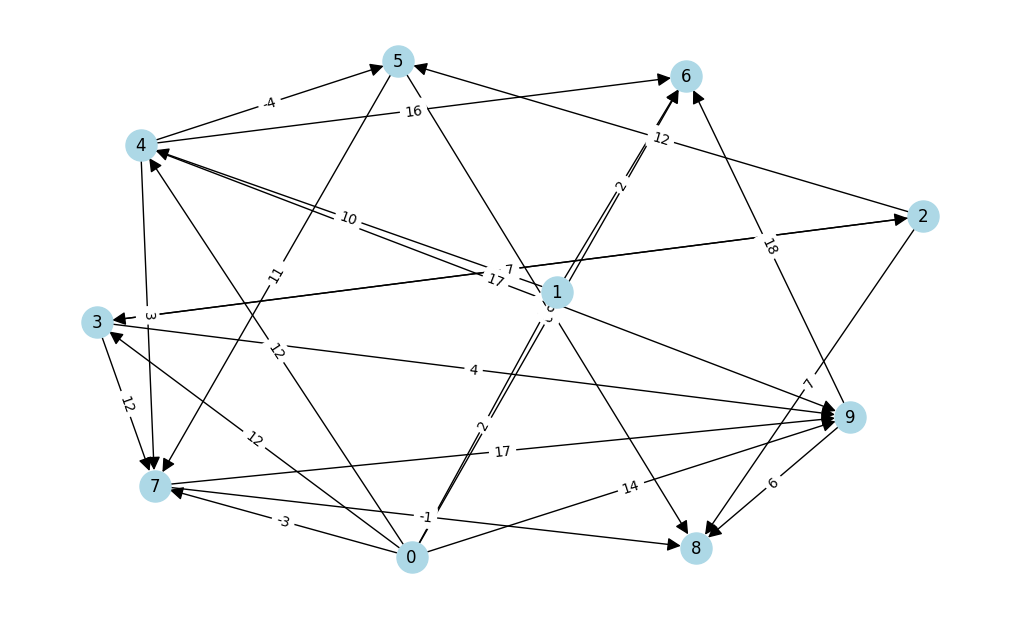

In [ ]:
G = gnp_random_connected_graph(10, 0.5, True, True)

In [ ]:
# pred is a dictionary of predecessors, dist is a dictionary of distances
try:
    pred, dist = bellman_ford_predecessor_and_distance(G, 0)
    for k, v in dist.items():
        print(f"Distance to {k}:", v)
except:
    print("Negative cycle detected")

Distance to 0: 0
Distance to 6: 4
Distance to 1: 2
Distance to 3: 12
Distance to 4: 12
Distance to 7: -3
Distance to 9: 14
Distance to 2: 19
Distance to 5: 8
Distance to 8: -4


### Custom function

In [ ]:
def bellman_ford_algorithm_pred_and_dist(graph, start):

    distance = {node: float('inf') for node in graph.nodes}
    predecessor = {node: None for node in graph.nodes}
    distance[start] = 0

    for _ in range(len(graph.nodes) - 1):
        for u, v, weight in graph.edges(data='weight'):
            if distance[u] + weight < distance[v]:
                distance[v] = distance[u] + weight
                predecessor[v] = u

    # Negative cycle detector iteration
    for u, v, weight in graph.edges(data='weight'):
        if distance[u] + weight < distance[v]:
            return None, None

    return predecessor, distance

In [ ]:
try:
    pred, dist = bellman_ford_algorithm_pred_and_dist(G, 0)
    for k, v in dist.items():
        print(f"Distance to {k}: {v}")
except:
    print("Negative cycle detected")

Distance to 0: 0
Distance to 1: 2
Distance to 2: 19
Distance to 3: 12
Distance to 4: 12
Distance to 5: 8
Distance to 6: 4
Distance to 7: -3
Distance to 8: -4
Distance to 9: 14


### Measuring execution time

In [ ]:
import time

def measure_execution_time(graph, algorithm_type='custom'):
    start_time = time.time()

    if algorithm_type == 'custom':
        bellman_ford_algorithm_pred_and_dist(G, 0)
    elif algorithm_type == 'networkx':
        bellman_ford_predecessor_and_distance(G, 0)

    end_time = time.time()
    return end_time - start_time

In [ ]:
def run_experiment(node_counts):
    results = {'custom': {'full': [], 'half': []}, 'networkx': {'full': [], 'half': []}}

    for nodes in node_counts:
        G_full = gnp_random_connected_graph(nodes, 1, True, False)

        custom_time = measure_execution_time(G_full, 'custom')
        networkx_time = measure_execution_time(G_full, 'networkx')
        results['custom']['full'].append(custom_time)
        results['networkx']['full'].append(networkx_time)

        G_half = gnp_random_connected_graph(nodes, 0.5, True, False)
        custom_time_half = measure_execution_time(G_half, 'custom')
        networkx_time_half = measure_execution_time(G_half, 'networkx')
        results['custom']['half'].append(custom_time_half)
        results['networkx']['half'].append(networkx_time_half)

    return results

node_counts = [10, 20, 50, 100, 200, 300, 600, 1000, 3000]
experiment_results = run_experiment(node_counts)

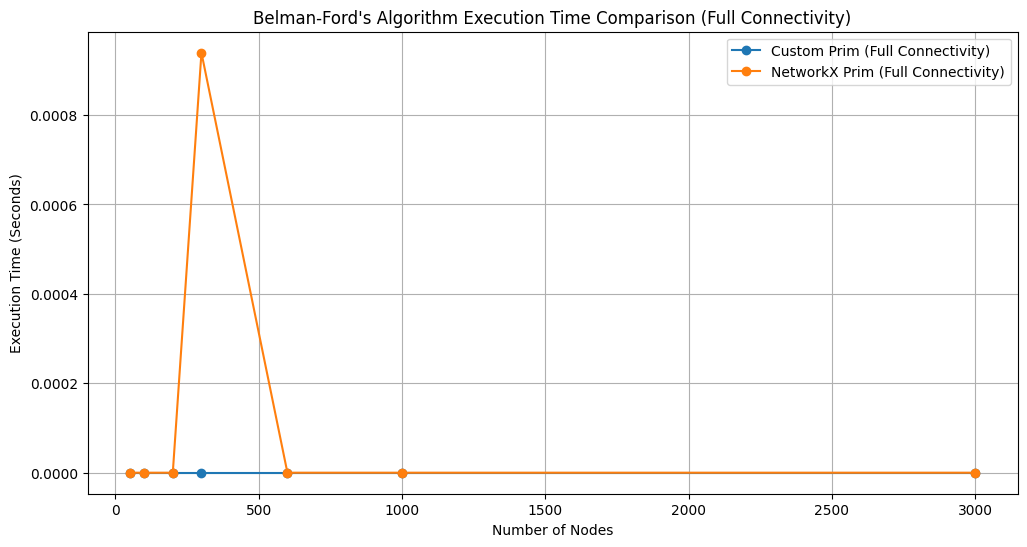

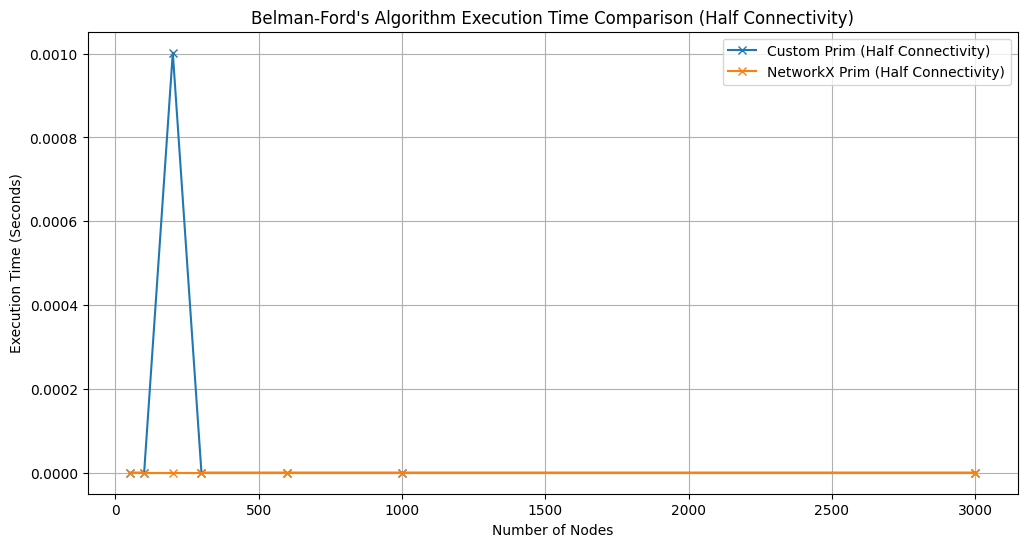

In [ ]:
def plot_results(experiment_results, node_counts):

    # completeness = 1
    plt.figure(figsize=(12, 6))

    plt.plot(node_counts, experiment_results['custom']['full'], label="Custom Prim (Full Connectivity)", marker='o')
    plt.plot(node_counts, experiment_results['networkx']['full'], label="NetworkX Prim (Full Connectivity)", marker='o')

    plt.xlabel("Number of Nodes")
    plt.ylabel("Execution Time (Seconds)")
    plt.title("Belman-Ford's Algorithm Execution Time Comparison (Full Connectivity)")
    plt.legend()

    plt.grid(True)
    plt.show()

    # completeness = 0.5
    plt.figure(figsize=(12, 6))

    plt.plot(node_counts, experiment_results['custom']['half'], label="Custom Prim (Half Connectivity)", marker='x')
    plt.plot(node_counts, experiment_results['networkx']['half'], label="NetworkX Prim (Half Connectivity)", marker='x')

    plt.xlabel("Number of Nodes")
    plt.ylabel("Execution Time (Seconds)")
    plt.title("Belman-Ford's Algorithm Execution Time Comparison (Half Connectivity)")
    plt.legend()

    plt.grid(True)
    plt.show()

plot_results(experiment_results, node_counts)

# Summary of Experiments (Bellman-Ford Algorithm)

## Full Connectivity Experiment
- The execution time of both the **Custom Bellman-Ford Algorithm** and the **NetworkX implementation** is nearly identical.
- The performance remains stable across different graph sizes, with no significant deviations.
- There is a small spike in execution time for the NetworkX implementation at around 500 nodes, but it quickly returns to normal.

## Half Connectivity Experiment
- Similar to the full connectivity case, both implementations exhibit almost identical execution times.
- The custom algorithm has a small spike in execution time at a certain point, but overall, both implementations perform equally well.
- Execution times remain low, indicating efficient handling of sparse graphs.

---

## General Conclusions
- **Performance Comparison**: Both the **Custom Bellman-Ford Algorithm** and the **NetworkX implementation** perform identically in terms of execution time.
- **Best Performance**: The algorithms work efficiently across all tested graph sizes, with minimal execution time differences.
- **Worst Performance**: No significant inefficiencies were observed in either implementation.
- **Key Observation**: Since Bellman-Ford has a well-defined time complexity of \(O(VE)\), both implementations behave as expected, demonstrating stable and efficient execution.

## Task 2. Decision Tree Classifier 

In [14]:
# scikit-learn package
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split

In [15]:
# Load dataset
iris = load_iris()
dir(iris)

['DESCR',
 'data',
 'data_module',
 'feature_names',
 'filename',
 'frame',
 'target',
 'target_names']

In [16]:
iris.data.shape

(150, 4)

### To undestand data little bit better, let's plot some features

Text(0, 0.5, 'Sepal width')

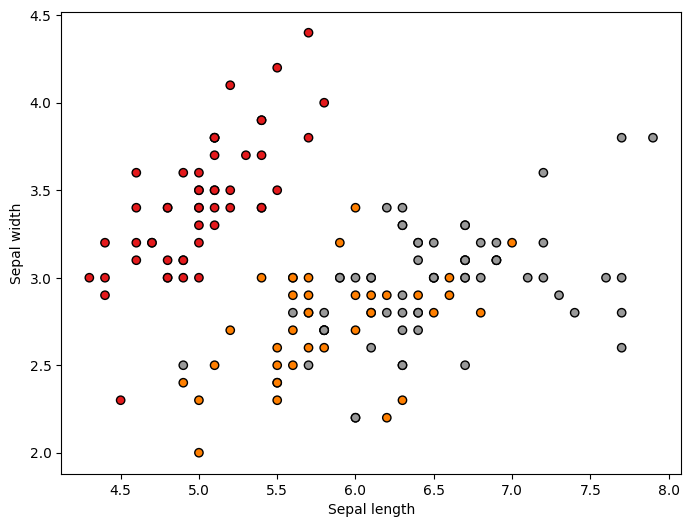

In [17]:
X = iris.data[:, :2]  # we only take the first two features.
y = iris.target

plt.figure(2, figsize=(8, 6))
plt.clf()

# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, edgecolor="k")
plt.xlabel("Sepal length")
plt.ylabel("Sepal width")

In [18]:
clf = DecisionTreeClassifier()

X, y = iris.data, iris.target
X.shape, y.shape

((150, 4), (150,))

In [19]:
X, X_test, y, y_test = train_test_split(X, y, test_size= 0.20)
X_test.shape, y_test.shape

((30, 4), (30,))

In [ ]:
class Node:
    def __init__(self, X: npt.NDArray, y: npt.NDArray, feature_index = 0, threshold = 0, left = None, right = None, is_leaf = False):
        """
        :param X: numpy array of form [[feature1,feature2, ... featureN], ...] (i.e. [[1.5, 5.4, 3.2, 9.8] , ...] for case with iris d.s.)
        :param y: numpy array of from [class1, class2, ...] (i.e. [0,1,1,2,1,0,...] for case with iris d.s.)
        """

        self.X = X
        self.y = y
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.is_leaf = is_leaf

In [ ]:
class DecisionTreeClassifier:
    def __init__(self, max_depth=5) -> None:
        self.max_depth = max_depth
        self.tree = None


    def fit(self, X: npt.NDArray, y: npt.NDArray) -> None:
        """
        Basically, function that performs all the training (building of a tree)
        We recommend to use it as a wrapper of recursive building function
        """

        self.tree = self.build_tree(X, y)


    def build_tree(self, X: npt.NDArray, y: npt.NDArray, curr_depth=0):
        """
        Recursive function that builds the tree
        """
        if curr_depth > self.max_depth:
            return Node(X, y, is_leaf=True)
        best_split = self.best_split(X, y)
        if best_split is None or best_split[0] <=0:
            return Node(X, y, is_leaf=True)
        left_tree = self.build_tree(best_split[3], best_split[4], curr_depth + 1)
        right_tree = self.build_tree(best_split[5], best_split[6], curr_depth + 1)
        return Node(X, y, best_split[1], best_split[2], left_tree, right_tree)


    def best_split(self, X, y):
        """
        Function that finds the best split for the given data
        """
        max_info_gain = -1
        best_split = None
        for i in range(X.shape[1]):
            thresholds = np.unique(X[:, i])
            for t in thresholds:
                left_X, left_y = [], []
                right_X, right_y = [], []
                for j,r in enumerate(X):
                    if r[i] <= t:
                        left_X.append(r)
                        left_y.append(y[j])
                    else:
                        right_X.append(r)
                        right_y.append(y[j])
                left_X = np.array(left_X)
                left_y = np.array(left_y)
                right_X = np.array(right_X)
                right_y = np.array(right_y)
                if len(left_X) == 0 or len(right_X) == 0:
                    continue
                info_gain = self.info_gain(left_y, right_y, y)
                if info_gain > max_info_gain:
                    max_info_gain = info_gain
                    best_split = (info_gain, i, t, left_X, left_y, right_X, right_y)
        return best_split


    def test_print(self, tree=None, d = 1):
        """
        Prints the tree
        """
        if not tree:
            tree = self.tree
        i = " "*d
        if tree.is_leaf:
            y = list(tree.y)
            print(f"{i}Leaf: (num of y: {len(y)})")
            return
        
        print(f"{i}Node: feat {tree.feature_index} <= {tree.threshold}")
        
        print(f"{i} - L:")
        self.test_print(tree.left, d + 1)  
        
        print(f"{i} - R:")
        self.test_print(tree.right, d + 1)  


    def info_gain(self, left, right, y):
        """
        Calculates information gain
        """
        weight_left = len(left) / len(y)
        weight_right = len(right) / len(y)
        return self.gini(y) - weight_left * self.gini(left) - weight_right * self.gini(right)
    

    def gini(self, y):
        '''
        Calculates gini impurity
        '''
        c = np.unique(y)
        gini = 0
        for cls in c:
            gini += (np.sum(y == cls) / len(y)) **2
        return 1 - gini

    
    def predict(self, X_test: npt.NDArray) -> list:
        """
        Traverse the tree while there is a child
        and return the predicted class for it 
        """
        return [self.predict_iter(x, self.tree) for x in X_test]


    def predict_iter(self, X_test, node):
        """
        Recursive function that predicts the class for the given data
        """
        if node.is_leaf:
            y = list(node.y)
            return max(y, key=y.count)
        if X_test[node.feature_index] <= node.threshold:
            return self.predict_iter(X_test, node.left)
        else:
            return self.predict_iter(X_test, node.right)


    def evaluate(self, X_test: list[list], y_test: list) -> float:
        """
        Returns accuracy of the model (ratio of right guesses to the number of samples)
        """
        predictions = self.predict(X_test)
        correct = np.sum( np.array(predictions) == np.array(y_test))
        return correct / len(y_test)


tree_test = DecisionTreeClassifier(5)
tree_test.fit(X, y)
tree_test.test_print()
print(tree_test.evaluate(X_test, y_test))

 Node: feat 2 <= 1.9
  - L:
  Leaf: (num of y: 39)
  - R:
  Node: feat 2 <= 4.7
   - L:
   Leaf: (num of y: 39)
   - R:
   Node: feat 3 <= 1.7
    - L:
    Node: feat 2 <= 4.9
     - L:
     Leaf: (num of y: 3)
     - R:
     Node: feat 3 <= 1.6
      - L:
      Leaf: (num of y: 4)
      - R:
      Leaf: (num of y: 1)
    - R:
    Leaf: (num of y: 34)
0.9


### Short code overview
- Our task for part 2 of this lab. project was to create a custom decisicion classifier tree, which is used to predict and classify data based on certain characteristics.
- For this task we used the iris dataset about flower types and certain features.
- This code consists of two python classes - Node (used to store nodes in a tree) and the main DecisionTreeClassifier class
- Node stores information such as data, currently in the node, is_leaf bool to determine whether this node has children or not, and if the node isn't a leaf, additional data is stored, such as the threshold and feature index
- The tree classifier itself contains a bunch of functions, such as
- - fit() is used as the main function to generate the tree inside of the class
- - build_tree() constructs the tree recursively by finding the best data split using the best_split() functions
- - best_split() finds all possible splits and calculates which one is the best based on it's information gain
- - info_gain() calculates information gain of a node using the gini formula
- - gini() calculates the gini impurity
- - predict() is used to predict the type based on parameters
- - predict_iter() an iteration of the predict algorithm
- - evaluate() finds the accuracy of this model
- - test_print() is used to visualise the tree in text mode